# DeepLab 
## Testing DeepLab with MobileNet

In [ ]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

helper_path = os.path.abspath(os.path.join('../helper'))
if helper_path not in sys.path:
    sys.path.append(helper_path)

In [2]:
from helper.models.config import *
from helper.models.deeplab_mobilenet import *
from helper.data.dataobj import DrainageDataset
from torch.utils.data import DataLoader
from helper.data.dataobj import DrainageDataset
from sklearn.model_selection import train_test_split
from helper.utilities import *
from helper.callbacks.logs import save_history_callback, save_resulting_callback
from helper.callbacks.visualize import draw_history_log, draw_resulting_log
from transformers import logging
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
logging.set_verbosity_error()

## Loading model

In [3]:
device = 'cuda'
deeplab_model = DeepLab(device=device)
deeplab_model.load('./helper/models/saved/DeepLabV3-1.pt')

Initialized DeepLabV3


In [4]:
config_deeplab = Config(
    model=deeplab_model,
    num_epochs=200,
    opt='Adam',
    lr=1e-4
)

## Dataset

In [5]:
images = np.load('./helper/data/datasets/new_images.npy').astype(np.uint8)
masks = np.load('./helper/data/datasets/new_masks.npy')

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print('Getting test dataset')
bins = [get_bin(mask) for mask in masks]

train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=test_ratio, stratify=bins, random_state=42)

test_dataset = DrainageDataset(test_images, test_masks, device=device, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Getting test dataset


## Testing model

In [6]:
details = deeplab_model.test_epoch(test_dataloader, config_deeplab.criterion, device='cuda', detailed=True)
save_resulting_callback(deeplab_model, metrics=details, hyperparams=config_deeplab.get_params())
print(f'Saved details of testing {deeplab_model.get_name()}')

Saved details of testing DeepLabV3


In [7]:
print(details)

{'loss': 0.033793127624898826, 'acc': 0.9904489517211914, 'prec': 0.7718234062194824, 'recall': 0.5863358974456787, 'f1': 0.6656646728515625, 'dice': 0.8140791654586792, 'iou': 0.49938082695007324}


## Visualizing

### Getting metrics vizualization

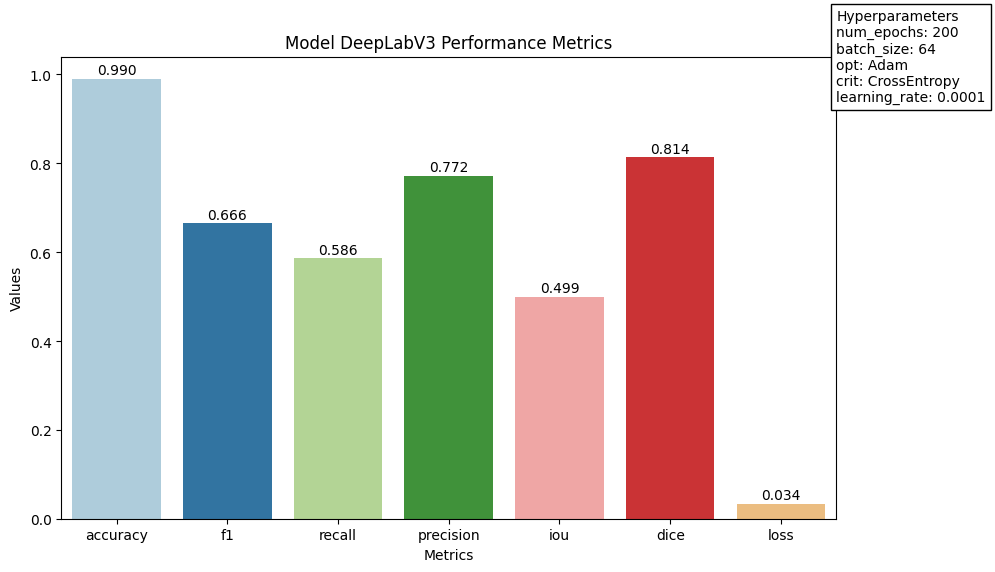

In [8]:
draw_resulting_log('DeepLabV3-1.json')

### Model's predicts examples

mask: torch.Size([256, 256])
inter: torch.Size([256, 256])


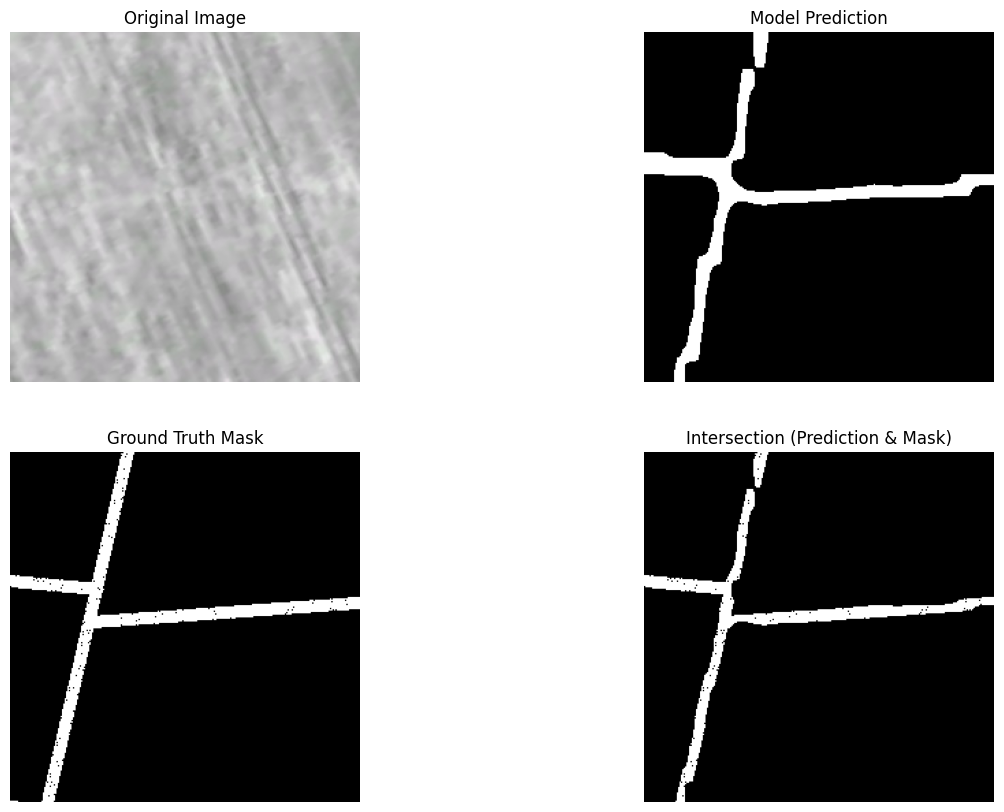

In [9]:
image, mask = test_dataset[10] # 0 1 10 11 12
deeplab_model.predict(image, mask, device)